<a href="https://colab.research.google.com/github/vaghyjuli/RL/blob/main/other_Continuous2_Lunar_Lander.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install gym[box2d]==0.17

import gym
import numpy as np
import pandas as pd
import random

from tensorflow import keras
import tensorflow as tf
from keras.activations import relu, linear

     |████████████████████████████████| 1.6 MB 4.5 MB/s 
     |████████████████████████████████| 448 kB 44.4 MB/s 
  Created wheel for gym: filename=gym-0.17.0-py3-none-any.whl size=1648707 sha256=09958c1cc2cb13bcbc580dd5208621976b8b8818d3ceecece6c1ca7bb719000e
  Stored in directory: /root/.cache/pip/wheels/bb/d6/e8/4c7bed6daf2593a6752cdd0b74906e59cf8c86a05a15ca77f0
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3


In [3]:
class Agent(tf.keras.Sequential):
  def __init__(self):
    super().__init__()

    self.epsilon = 1
    self.min_eps = 0.01
    self.gamma = .99
    self.batch_size = 64
    self.learning_rate = 0.001

    self.memory_size = 10000
    self.memory = []
    self.memory_number = 0

    self.add(keras.layers.Dense(64, input_dim=8, activation=relu))
    self.add(keras.layers.Dense(64, activation=relu))
    self.add(keras.layers.Dense(4, activation=linear))
    self.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate))

  def get_action(self, state):
    if np.random.random() <= self.epsilon:
      return np.random.choice(4)
    else:
      action_values = self.predict(state)
      return np.argmax(action_values[0])

  def remember(self, experience):
    if self.memory_number < self.memory_size:
      self.memory.append(experience)
    else:
      idx = self.memory_number % self.memory_size
      self.memory[idx] = experience
    self.memory_number += 1

  def replay_experiences(self):
    if self.memory_number < self.memory_size:
      return

    mini_batch_index = np.random.choice(len(self.memory), self.batch_size)
    #batch = random.sample(self.memory, self.batch_size)

    states = np.squeeze(np.array([self.memory[idx][0] for idx in mini_batch_index]))
    actions = np.array([self.memory[idx][1] for idx in mini_batch_index])
    next_states = np.squeeze(np.array([self.memory[idx][2] for idx in mini_batch_index]))
    rewards = np.array([self.memory[idx][3] for idx in mini_batch_index])
    finishes = np.array([self.memory[idx][4] for idx in mini_batch_index])

    q_vals_next_state = self.predict_on_batch(next_states)
    q_vals_target = self.predict_on_batch(states)
    max_q_values_next_state = np.amax(q_vals_next_state, axis=1)
    q_vals_target[np.arange(self.batch_size), actions] = rewards + self.gamma * (max_q_values_next_state) * (1 - finishes)
    #self.fit(states, q_vals_target, verbose=0)
    self.train_on_batch(states, q_vals_target)
    
    if self.epsilon > self.min_eps:
        self.epsilon *= 0.999

In [4]:
agent = Agent()
env = gym.make('LunarLander-v2')
# env.seed(0)
# np.random.seed(0)
num_episodes = 300
scores  = []
timesteps = []
epsilons = []
for i in range(num_episodes):
  score = 0
  t = 0
  state = env.reset()
  done = False
  if i != 0 and i % 50 == 0:
    agent.save(".\saved_models\model_"+str(i)+"_episodes.h5")
  while True:
    t += 1
    state = np.reshape(state, (1, 8))
    action = agent.get_action(state)
    next_state, reward, done, metadata = env.step(action)
    next_state = np.reshape(next_state, (1, 8))
    agent.remember((state, action, next_state, reward, done))
    score += reward
    state = next_state
    agent.replay_experiences()
    if done:
      scores.append(score)
      timesteps.append(t)
      epsilons.append(agent.epsilon)
      print("Episode = {}, Score = {}, Avg_Score = {}".format(i, score, np.mean(scores[-100:])))
      break

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode = 0, Score = -83.78019398592593, Avg_Score = -83.78019398592593
Episode = 1, Score = -247.74029064453413, Avg_Score = -165.76024231523002
Episode = 2, Score = -308.6356434469855, Avg_Score = -213.3853760258152
Episode = 3, Score = -202.9094563202442, Avg_Score = -210.76639609942245
Episode = 4, Score = -333.5472134967963, Avg_Score = -235.3225595788972
Episode = 5, Score = -177.29076177050553, Avg_Score = -225.6505932774986
Episode = 6, Score = -98.82345459842786, Avg_Score = -207.5324306090599
Episode = 7, Score = 26.43178285277449, Avg_Score = -178.2869039263306
Episode = 8, Score = -121.52569263416399, Avg_Score = -171.98010267164543
Episode = 9, Score = -117.23064395180583, Avg_Score = -166.50515679966148
Episode = 10, Score = -109.88743763414752, Avg_Score = -161.35809142097838
Episode = 11, Score = -335.1330334076384, Avg_Score = -175.8393365865334
Episode = 12, Score = -103.36418275918756, Avg_Score = -170.26432475366067
Episode = 13, Score = -39.92106802853509, Avg_Scor

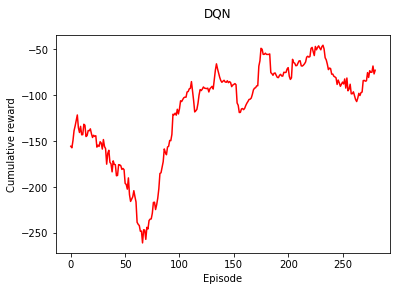

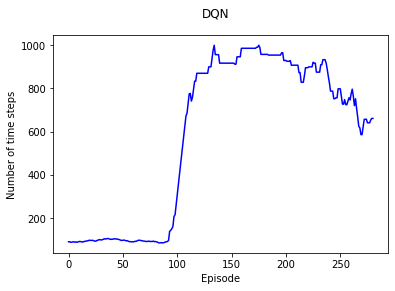

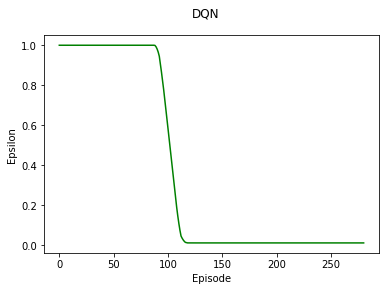

In [8]:
import matplotlib.pyplot as plt

kernel_size = 20
kernel = np.ones(kernel_size) / kernel_size
# cr = np.convolve(np.mean(scores, axis=0), kernel, mode="valid")
# tst = np.convolve(np.mean(timesteps, axis=0), kernel, mode="valid")
cr = np.convolve(scores, kernel, mode="valid")
tst = np.convolve(timesteps, kernel, mode="valid")
eps = np.convolve(epsilons, kernel, mode="valid")

rew = plt.figure(1)
plt.plot(cr, color="red")
plt.suptitle('DQN')
plt.xlabel('Episode')
plt.ylabel('Cumulative reward')
plt.show()


timest = plt.figure(2)
plt.plot(tst, color="blue")
plt.suptitle('DQN')
plt.xlabel('Episode')
plt.ylabel('Number of time steps')
timest.show()

timest = plt.figure(3)
plt.plot(eps, color="green")
plt.suptitle('DQN')
plt.xlabel('Episode')
plt.ylabel('Epsilon')
timest.show()